In [1]:
# Import lib
# ===========================================================
import csv
import pandas as pd
import numpy as np
import random
import time
import collections
import math
import sys
from tqdm import tqdm
from time import sleep

import matplotlib.pyplot as plt
# %matplotlib inline
plt.style.use('fivethirtyeight')

from datascience import *
from scipy import stats

import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
# Initialize useful data
# ===========================================================
# with open('clinvar_conflicting_mapped.csv', 'r') as f:
#     reader = csv.reader(f)
#     temp_rows = list(reader)
df = pd.read_csv('clinvar_conflicting_mapped.csv', low_memory=False)
df_zero = df.loc[df['CLASS'] == 0]
df_zero = df_zero.sample(n=10000)
df_one = df.loc[df['CLASS'] == 1]
df_one = df_one.sample(n=10000)

df = pd.concat([df_zero, df_one])
df = df.sample(n = df.shape[0])
all_rows = df.values.tolist()
row_num = len(all_rows)
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDN,CLNHGVS,...,Codons,STRAND,BAM_EDIT,SIFT,PolyPhen,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62,CLASS
54663,0.625000,0.727989,0.764434,0.567686,0.000000,0.970901,0.126018,0.829218,0.118143,0.928054,...,0.671769,0.9375,0.666667,0.8,0.8,0.966901,0.431452,0.053733,0.000000,1
47004,0.458333,0.308833,0.815242,0.661572,0.000000,0.490925,0.643987,0.508664,0.072246,0.466528,...,0.766772,0.0625,0.666667,0.8,0.8,0.043639,0.059524,0.659203,0.000000,0
18777,0.291667,0.858829,0.578522,0.746725,0.066502,0.739763,0.000000,0.099740,0.021598,0.626097,...,0.342638,0.0625,0.666667,0.8,0.8,0.787907,0.805300,0.290346,0.000000,0
306,0.875000,0.831894,0.578522,0.746725,0.000000,0.000000,0.000000,0.310266,0.123110,0.505047,...,0.112112,0.9375,0.666667,0.6,0.2,0.193972,0.430684,0.106834,0.999924,1
29969,0.791667,0.635602,0.815242,0.661572,0.721675,0.614369,0.515573,0.075590,0.056911,0.778195,...,0.946871,0.9375,0.666667,0.6,0.2,0.779031,0.262481,0.081224,0.000000,0


In [3]:
df = df.sample(n = df.shape[0])
all_rows = df.values.tolist()
row_num = len(all_rows)

In [4]:
# Divide whole dataset into training set and testing set
# ===========================================================
training_percentage = 0.01  # percent of partition of training dataset
training_size = int(row_num * training_percentage)
testing_size = row_num - training_size
trainingframe = df.iloc[: training_size]
testingframe = df.iloc[training_size: ]
trainingset = Table.from_df(trainingframe)
testingset = Table.from_df(testingframe)

In [10]:
# Train Model
# ===========================================================
formula = 'CLASS ~ CHROM + POS + REF + ALT + AF_ESP + AF_EXAC + AF_TGP + CLNDISDB + CLNDN + CLNVC + CLNVI + MC + ORIGIN + Allele + Consequence + IMPACT + SYMBOL + Feature_type + Feature + BIOTYPE + EXON + INTRON + cDNA_position + CDS_position + Protein_position + Amino_acids + Codons + STRAND + BAM_EDIT + SIFT + PolyPhen + LoFtool + CADD_PHRED + CADD_RAW + BLOSUM62'
# formula = 'CLASS ~ CHROM + POS + REF + ALT + AF_ESP + AF_EXAC + AF_TGP + CLNDISDB + CLNDN'
# selected_attribute = ['CHROM',
#  'POS',
#  'REF',
#  'ALT',
#  'AF_ESP',
#  'AF_EXAC',
#  'AF_TGP',
#  'CLNDISDB',
#  'CLNDN']
# i removed 'CLNHGVS'
# formula = 'CLASS ~ CLNVC + CLNVI + MC + ORIGIN + Allele + Consequence + IMPACT + SYMBOL'
# formula = 'CLASS ~ Feature_type + Feature + BIOTYPE + EXON + INTRON + cDNA_position'
# formula = 'CLASS ~ CDS_position + Protein_position + Amino_acids + Codons + STRAND + BAM_EDIT'
# formula = 'CLASS ~ SIFT + PolyPhen + LoFtool + CADD_PHRED + CADD_RAW + BLOSUM62'
start = time.time()
model = smf.glm(formula=formula, data=trainingframe, 
                family=sm.families.Binomial(
                link=sm.genmod.families.links.logit))
result = model.fit()
# result.summary()
end = time.time()
print("Logistic Regression Model Trained! Time: %.03fs" % (end - start))

Logistic Regression Model Trained! Time: 0.158s


/Users/frostace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.


In [11]:
# Compare Actual label and Predicted label
# ===========================================================
pred = result.predict(testingset.to_df())
final = Table().with_column('IDX', [i for i in range(len(pred))])
final = final.with_columns('ACT_CLASS', testingset.select('CLASS').to_df()[['CLASS']].transpose().values.tolist()[0], 'PRE_CLASS', pred.to_numpy())

In [12]:
final.show(5)

IDX,ACT_CLASS,PRE_CLASS
0,1,0.884723
1,0,0.260021
2,0,0.252895
3,0,0.838801
4,0,0.158827


In [13]:
# Compute TN, TP, FN, FP, etc.
# ===========================================================
ROC = Table(make_array('CUTOFF', 'TN', 'FN', 'FP', 'TP', 'ACC'))
step_size = 0.05
for cutoff in np.arange(0, 1 + step_size, step_size):
    temp_final = final.with_column('INDICATE', final.apply(lambda x, y: (int(x >= cutoff) << 1) + y, 'PRE_CLASS', 'ACT_CLASS'))
    # 00(0) -> TN
    # 01(1) -> FN
    # 10(2) -> FP
    # 11(3) -> TP
    group = temp_final.group('INDICATE')
    indicator = group.column(0)
    counts = group.column(1)
#     print(indicator, counts)
    output = [cutoff]
    idx = 0
    for i in range(4):
#         print(counts[idx])
        if i in indicator:
            output.append(counts[idx])
            idx += 1
        else:
            output.append(0)
    acc = (output[1] + output[4]) / sum(output[1:])
    output.append(acc)
    ROC = ROC.with_row(output)
ROC = ROC.with_columns('SENSITIVITY', ROC.apply(lambda TP, FN: TP / (TP + FN + 0.00000001), 'TP', 'FN'))
ROC = ROC.with_columns('FPR', ROC.apply(lambda TN, FP: FP / (TN + FP + 0.00000001), 'TN', 'FP'))
ROC = ROC.with_column('FMEAS', ROC.apply(lambda TP, FP, FN: 2 * (TP / (TP + FN)) * (TP / (TP + FP)) / (TP / (TP + FN) + TP / (TP + FP)), 'TP', 'FP', 'FN'))

In [14]:
ROC.show()

CUTOFF,TN,FN,FP,TP,ACC,SENSITIVITY,FPR
0,0,0,9892,9908,0.500404,1,1
0.05,442,364,9450,9544,0.504343,0.963262,0.955317
0.1,799,677,9093,9231,0.506566,0.931671,0.919228
0.15,1305,1043,8587,8865,0.513636,0.894732,0.868075
0.2,1870,1470,8022,8438,0.520606,0.851635,0.810958
0.25,2499,2001,7393,7907,0.525556,0.798042,0.747372
0.3,3244,2638,6648,7270,0.53101,0.733751,0.672058
0.35,4039,3370,5853,6538,0.534192,0.659871,0.59169
0.4,4858,4141,5034,5767,0.536616,0.582055,0.508896
0.45,5606,4963,4286,4945,0.532879,0.499092,0.433279


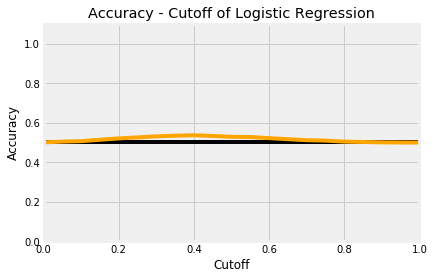

In [20]:
# Acc Curve by cutoff
# ===========================================================
fig = plt.figure()
plt.xlabel('Cutoff')
plt.ylabel('Accuracy')
plt.title('Accuracy - Cutoff of Logistic Regression')
plt.plot(np.arange(0, 1.1, 0.1), [0.5 for i in np.arange(0, 1.1, 0.1)], color='black')
plt.plot(ROC.column('CUTOFF'), ROC.column('ACC'), color='orange')
plt.axis([0, 1, 0, 1.1])
plt.show()
fig.savefig('Logistic ACC.png', bbox_inches='tight')

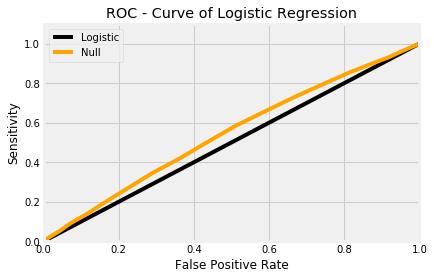

In [19]:
# ROC_CURVE
# ===========================================================
fig = plt.figure()
plt.xlabel('False Positive Rate')
plt.ylabel('Sensitivity')
plt.title('ROC - Curve of Logistic Regression')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), color='black')
plt.plot(ROC.column('FPR'), ROC.column('SENSITIVITY'), color='orange')
plt.legend(['Logistic', 'Null'])
plt.axis([0, 1, 0, 1.1])
plt.show()
fig.savefig('Logistic ROC.png', bbox_inches='tight')

In [18]:
# Compute AUC
# ===========================================================
length = len(ROC.column('FPR'))
auc = 0
for i in range(length - 1):
    auc += 0.5 * abs(ROC.column('FPR')[i + 1] - ROC.column('FPR')[i]) * (ROC.column('SENSITIVITY')[i] + ROC.column('SENSITIVITY')[i + 1])
print("auc = %.03f" %auc)

auc = 0.544


In [13]:
# import sklearn
# from sklearn.linear_model import LogisticRegression
# from sklearn.cross_validation import train_test_split

# # Normalize grades to values between 0 and 1 for more efficient computation
# normalized_range = sklearn.preprocessing.MinMaxScaler(feature_range=(-1,1))

# # Extract Features + Labels
# labels.shape =  (100,) #scikit expects this
# features = normalized_range.fit_transform(features)

# # Create Test/Train
# features_train,features_test,labels_train,labels_test = train_test_split(features,labels,test_size=0.4)

# # Scikit Logistic Regression
# scikit_log_reg = LogisticRegression()
# scikit_log_reg.fit(features_train,labels_train)

# #Score is Mean Accuracy
# scikit_score = clf.score(features_test,labels_test)
# print('Scikit score: ', scikit_score)

In [21]:
a, b = ROC.column('FPR'), ROC.column('SENSITIVITY')

In [22]:
a

array([1.00000000e+00, 9.55317428e-01, 9.19227659e-01, 8.68075212e-01,
       8.10958350e-01, 7.47371613e-01, 6.72058229e-01, 5.91690255e-01,
       5.08896078e-01, 4.33279418e-01, 3.61302062e-01, 2.88313789e-01,
       2.20279013e-01, 1.62454509e-01, 1.16255560e-01, 7.25839062e-02,
       4.16498180e-02, 1.73877881e-02, 4.85240598e-03, 4.04367165e-04,
       0.00000000e+00])

In [23]:
b

array([1.00000000e+00, 9.63262010e-01, 9.31671377e-01, 8.94731530e-01,
       8.51635042e-01, 7.98041986e-01, 7.33750505e-01, 6.59870811e-01,
       5.82054905e-01, 4.99091643e-01, 4.18247881e-01, 3.43863545e-01,
       2.64331853e-01, 1.96205087e-01, 1.39685103e-01, 9.20468308e-02,
       5.06661284e-02, 2.30117077e-02, 6.96406944e-03, 8.07428341e-04,
       0.00000000e+00])

In [24]:
ROC.column('ACC')

array([0.50040404, 0.50434343, 0.50656566, 0.51363636, 0.52060606,
       0.52555556, 0.5310101 , 0.53419192, 0.53661616, 0.53287879,
       0.52838384, 0.52762626, 0.52181818, 0.51661616, 0.51141414,
       0.50939394, 0.50414141, 0.50242424, 0.50065657, 0.49979798,
       0.49959596])